## Customer Lifetime Value Prediction Model

#### (to stop or ignore warnings)

In [34]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Load and Understand Your Dataset

In [35]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset with encoding fix
df = pd.read_csv("customer_segmentation.csv", encoding='ISO-8859-1')

# Show sample data and column names
print("Columns:", df.columns)
print(df.head())

Columns: Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


### Preprocessing

In [36]:
# Rename columns for consistency if needed
# df.rename(columns={'YourOrderColumn': 'OrderAmount', ...}, inplace=True)

# Convert date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Drop rows with missing dates or amounts
df.dropna(subset=['CustomerID', 'InvoiceDate', 'UnitPrice'], inplace=True)

### Create RFM Features

In [37]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

df['Amount'] = df['Quantity'] * df['UnitPrice']
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                                     # Frequency
    'Amount': 'sum'                                             # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

### Build Regression Model

In [38]:
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### Evaluation

In [39]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"Mean Squared Error: {rmse:.2f}")

Mean Absolute Error: 1773.74
Mean Squared Error: 10100.72


### Predict and segment

In [40]:
rfm['Predicted_LTV'] = model.predict(X)
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], q=3, labels=['Low', 'Medium', 'High'])

### Visualization

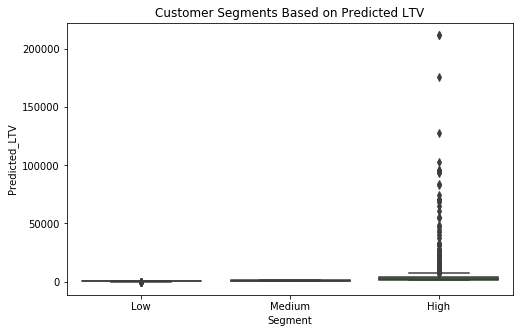

In [41]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=rfm, x='Segment', y='Predicted_LTV')
plt.title("Customer Segments Based on Predicted LTV")
plt.show()

### Results

In [42]:
rfm.to_csv("customer_ltv_segments.csv", index=False)
print("Results saved to customer_ltv_segments.csv")

Results saved to customer_ltv_segments.csv


### Output

- Predicted LTV for each customer
- Segments (Low, Medium, High)
- CSV file: customer_ltv_segments.csv
- Boxplot of LTV by segment